(1440, 1080, 3)


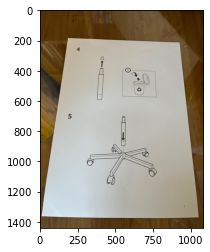

In [108]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


a = cv2.imread('./pict.jpg')
gray = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)
print(a.shape)
plt.imshow(gray)
plt.show()

# 코너 이용한 종이 검출 - 실패

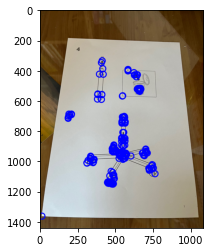

In [92]:
img = cv2.imread('pict.jpg')
img = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gray, 200, 0.05, 2, blockSize=3, useHarrisDetector=True, k=0.03)
for i in corners:
    cv2.circle(img, tuple(map(int, i[0])), 20, (0, 0, 255), 5)

plt.imshow(img)
plt.show()

In [78]:
tuple(map(int, corners[0][0]))

(479, 936)

# 단순 외곽선 이용 종이 검출 - 실패?

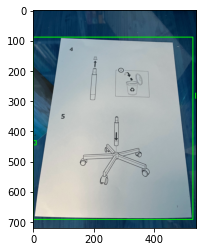

In [47]:
img = cv2.imread('pict.jpg')
rgb = cv2.pyrDown(img)
small = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
grad = cv2.morphologyEx(small, cv2.MORPH_GRADIENT, kernel)
_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
mask = np.zeros(bw.shape, dtype=np.uint8)

tmp = []
for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx])
    mask[y:y+h, x:x+w] = 0
    cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)
    r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)

    cv2.rectangle(rgb, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)
    tmp.append(rgb[y:y+h-1, x:x+w-1])

plt.imshow(rgb)
plt.show()

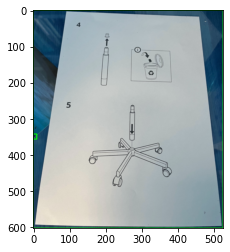

In [50]:
plt.imshow(tmp[2])
plt.show()

# 종이 검출 - 성공한 거

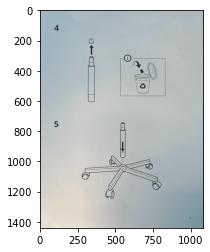

In [109]:
def reorderPts(pts): # 꼭지점 순서 정렬
    idx = np.lexsort((pts[:, 1], pts[:, 0]))  # 칼럼0 -> 칼럼1 순으로 정렬한 인덱스를 반환
    pts = pts[idx]  # x좌표로 정렬
    
    if pts[0, 1] > pts[1, 1]:
        pts[[0, 1]] = pts[[1, 0]] # 스와핑

    if pts[2, 1] < pts[3, 1]:
        pts[[2, 3]] = pts[[3, 2]] # 스와핑

    return pts

# output 세로, 가로 크기
dw, dh = 1080, 1440
srcQuad = np.array([[0, 0], [0, 0], [0, 0], [0, 0]], np.float32)
dstQuad = np.array([[0, 0], [0, dh], [dw, dh], [dw, 0]], np.float32)
img = cv2.imread('pict.jpg')
src_gray = cv2.cvtColor(a, cv2.COLOR_RGB2GRAY)
_, src_bin = cv2.threshold(src_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# 외곽선 검출 및 명함 검출
contours, _ = cv2.findContours(src_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

cpy = img.copy()
for pts in contours:
    # 너무 작은 객체는 무시
    if cv2.contourArea(pts) < 1000:
        continue

    # 외곽선 근사화
    approx = cv2.approxPolyDP(pts, cv2.arcLength(pts, True)*0.02, True)

    # 컨벡스가 아니고, 사각형이 아니면 무시
    if not cv2.isContourConvex(approx) or len(approx) != 4:
        continue

    cv2.polylines(cpy, [approx], True, (0, 255, 0), 2, cv2.LINE_AA)
    srcQuad = reorderPts(approx.reshape(4, 2).astype(np.float32))

pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
dst = cv2.warpPerspective(img, pers, (dw, dh))
plt.imshow(dst)
plt.show()

In [110]:
cv2.imwrite('./ttee.jpg',dst)

True

# 추출한 종이 사진에서 숫자 검출

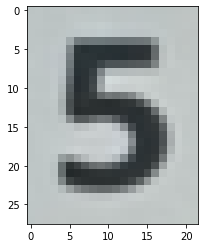

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('ttee.jpg')
img = cv2.pyrDown(img)
rgb = img.copy()
small = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
grad = cv2.morphologyEx(small, cv2.MORPH_GRADIENT, kernel)
_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
mask = np.zeros(bw.shape, dtype=np.uint8)

tmp = []
for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx])
    mask[y:y+h, x:x+w] = 0
    cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)
    r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)
    if r > 0.45 and w > 8 and w < 50 and h > 8:
        cv2.rectangle(rgb, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)
        tmp.append(img[y:y+h-1, x:x+w-1])
        
# cv2.imshow('rects', large)
# cv2.waitKey()

plt.imshow(tmp[1])
plt.show()

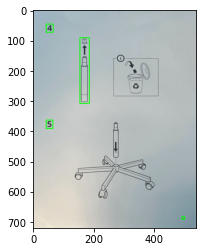

In [20]:
plt.imshow(rgb)
plt.show()

### 흑백 이진화

In [96]:
ttt = cv2.cvtColor(tmp[1], cv2.COLOR_RGB2GRAY)
ret, dst = cv2.threshold(ttt, 130, 255, cv2.THRESH_BINARY)

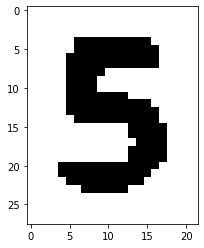

In [97]:
plt.imshow(dst, cmap='gray')
plt.show()

# CNN 모델 결과 출력 - 예측 실패

In [103]:
ttt = cv2.cvtColor(tmp[1], cv2.COLOR_RGB2GRAY)
at = cv2.resize(ttt, (32,32), interpolation = cv2.INTER_AREA)
td = cv2.cvtColor(at, cv2.COLOR_GRAY2BGR)
ret, dst = cv2.threshold(td, 130, 255, cv2.THRESH_BINARY)

<BarContainer object of 10 artists>

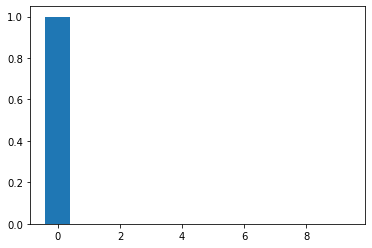

In [104]:
import keras
import matplotlib.pyplot as plt

# 저장된 모델 가져오기
load_model = keras.models.load_model('./number_classification.h5')

pred = load_model.predict(dst.reshape(1, 32, 32, 3))
plt.bar(range(10), pred[0])

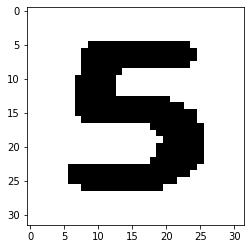

In [105]:
plt.imshow(dst)
plt.show()